In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install -q kaggle
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jahanvidave","key":"b920dec3173c517a921b70ac4bb81162"}'}

# AGR Model

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jangedoo/utkface-new

 99% 327M/331M [00:03<00:00, 97.3MB/s]
100% 331M/331M [00:03<00:00, 87.5MB/s]


In [5]:
!unzip -q utkface-new.zip

In [6]:
# Read dataset and assign labels
DATA_DIR = "./UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

AGE_ID_MAP={
    'below_20':0,
     '20-30':1,
    '30-40':2,
    '40-50':3,
    'above_50':4
}

ID_AGE_MAP = dict((r, i) for i, r in AGE_ID_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP, ID_AGE_MAP, AGE_ID_MAP

({0: 'male', 1: 'female'},
 {'female': 1, 'male': 0},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'asian': 2, 'black': 1, 'indian': 3, 'others': 4, 'white': 0},
 {0: 'below_20', 1: '20-30', 2: '30-40', 3: '40-50', 4: 'above_50'},
 {'20-30': 1, '30-40': 2, '40-50': 3, 'above_50': 4, 'below_20': 0})

In [7]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        

In [8]:
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
attributes = list(map(parse_filepath, files))

./UTKFace/61_1_20170109150557335.jpg.chip.jpg
./UTKFace/61_1_20170109142408075.jpg.chip.jpg
./UTKFace/39_1_20170116174525125.jpg.chip.jpg


In [9]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age2', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age2,gender,race,file
0,50.0,male,white,./UTKFace/50_0_0_20170117160733057.jpg.chip.jpg
1,26.0,female,black,./UTKFace/26_1_1_20170116232809522.jpg.chip.jpg
2,19.0,female,indian,./UTKFace/19_1_3_20170119192850574.jpg.chip.jpg
3,40.0,female,asian,./UTKFace/40_1_2_20170116191629950.jpg.chip.jpg
4,1.0,female,asian,./UTKFace/1_1_2_20161219153439021.jpg.chip.jpg


In [10]:
# Filter age into 5 classes
df["age2"] = pd.to_numeric(df["age2"])
df["age"] = ''
df['age'] = np.where(df['age2']>50, 'above_50', df['age'])
df['age'] = np.where((df['age2']>40)*(df['age2']<=50), '40-50', df['age'])
df['age'] = np.where((df['age2']>30)*(df['age2']<=40), '30-40', df['age'])
df['age'] = np.where((df['age2']>20)*(df['age2']<=30), '20-30', df['age'])
df['age'] = np.where(df['age2']<=20, 'below_20', df['age'])

df.head()  

,age2,gender,race,file,age
0,50.0,male,white,./UTKFace/50_0_0_20170117160733057.jpg.chip.jpg,40-50
1,26.0,female,black,./UTKFace/26_1_1_20170116232809522.jpg.chip.jpg,20-30
2,19.0,female,indian,./UTKFace/19_1_3_20170119192850574.jpg.chip.jpg,below_20
3,40.0,female,asian,./UTKFace/40_1_2_20170116191629950.jpg.chip.jpg,30-40
4,1.0,female,asian,./UTKFace/1_1_2_20161219153439021.jpg.chip.jpg,below_20


In [11]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])
df['age_id'] = df['age'].map(lambda age: AGE_ID_MAP[age])

In [12]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age_id'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(to_categorical(age, len(AGE_ID_MAP)))
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [28]:
# Design Multi-Task CNN
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
x = Conv2D(filters=32, kernel_size=3, activation='relu')(input_layer)

x = Conv2D(filters=32*2, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=32*3, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=32*4, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=32*5, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=32*6, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
bottleneck = GlobalMaxPool2D()(x)

# for age
x = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=len(AGE_ID_MAP), activation='softmax', name='age_output')(x)
# for race
x = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(x)

# for gender
x = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(x)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'categorical_crossentropy', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'accuracy', 'race_output': 'accuracy', 'gender_output': 'accuracy'})


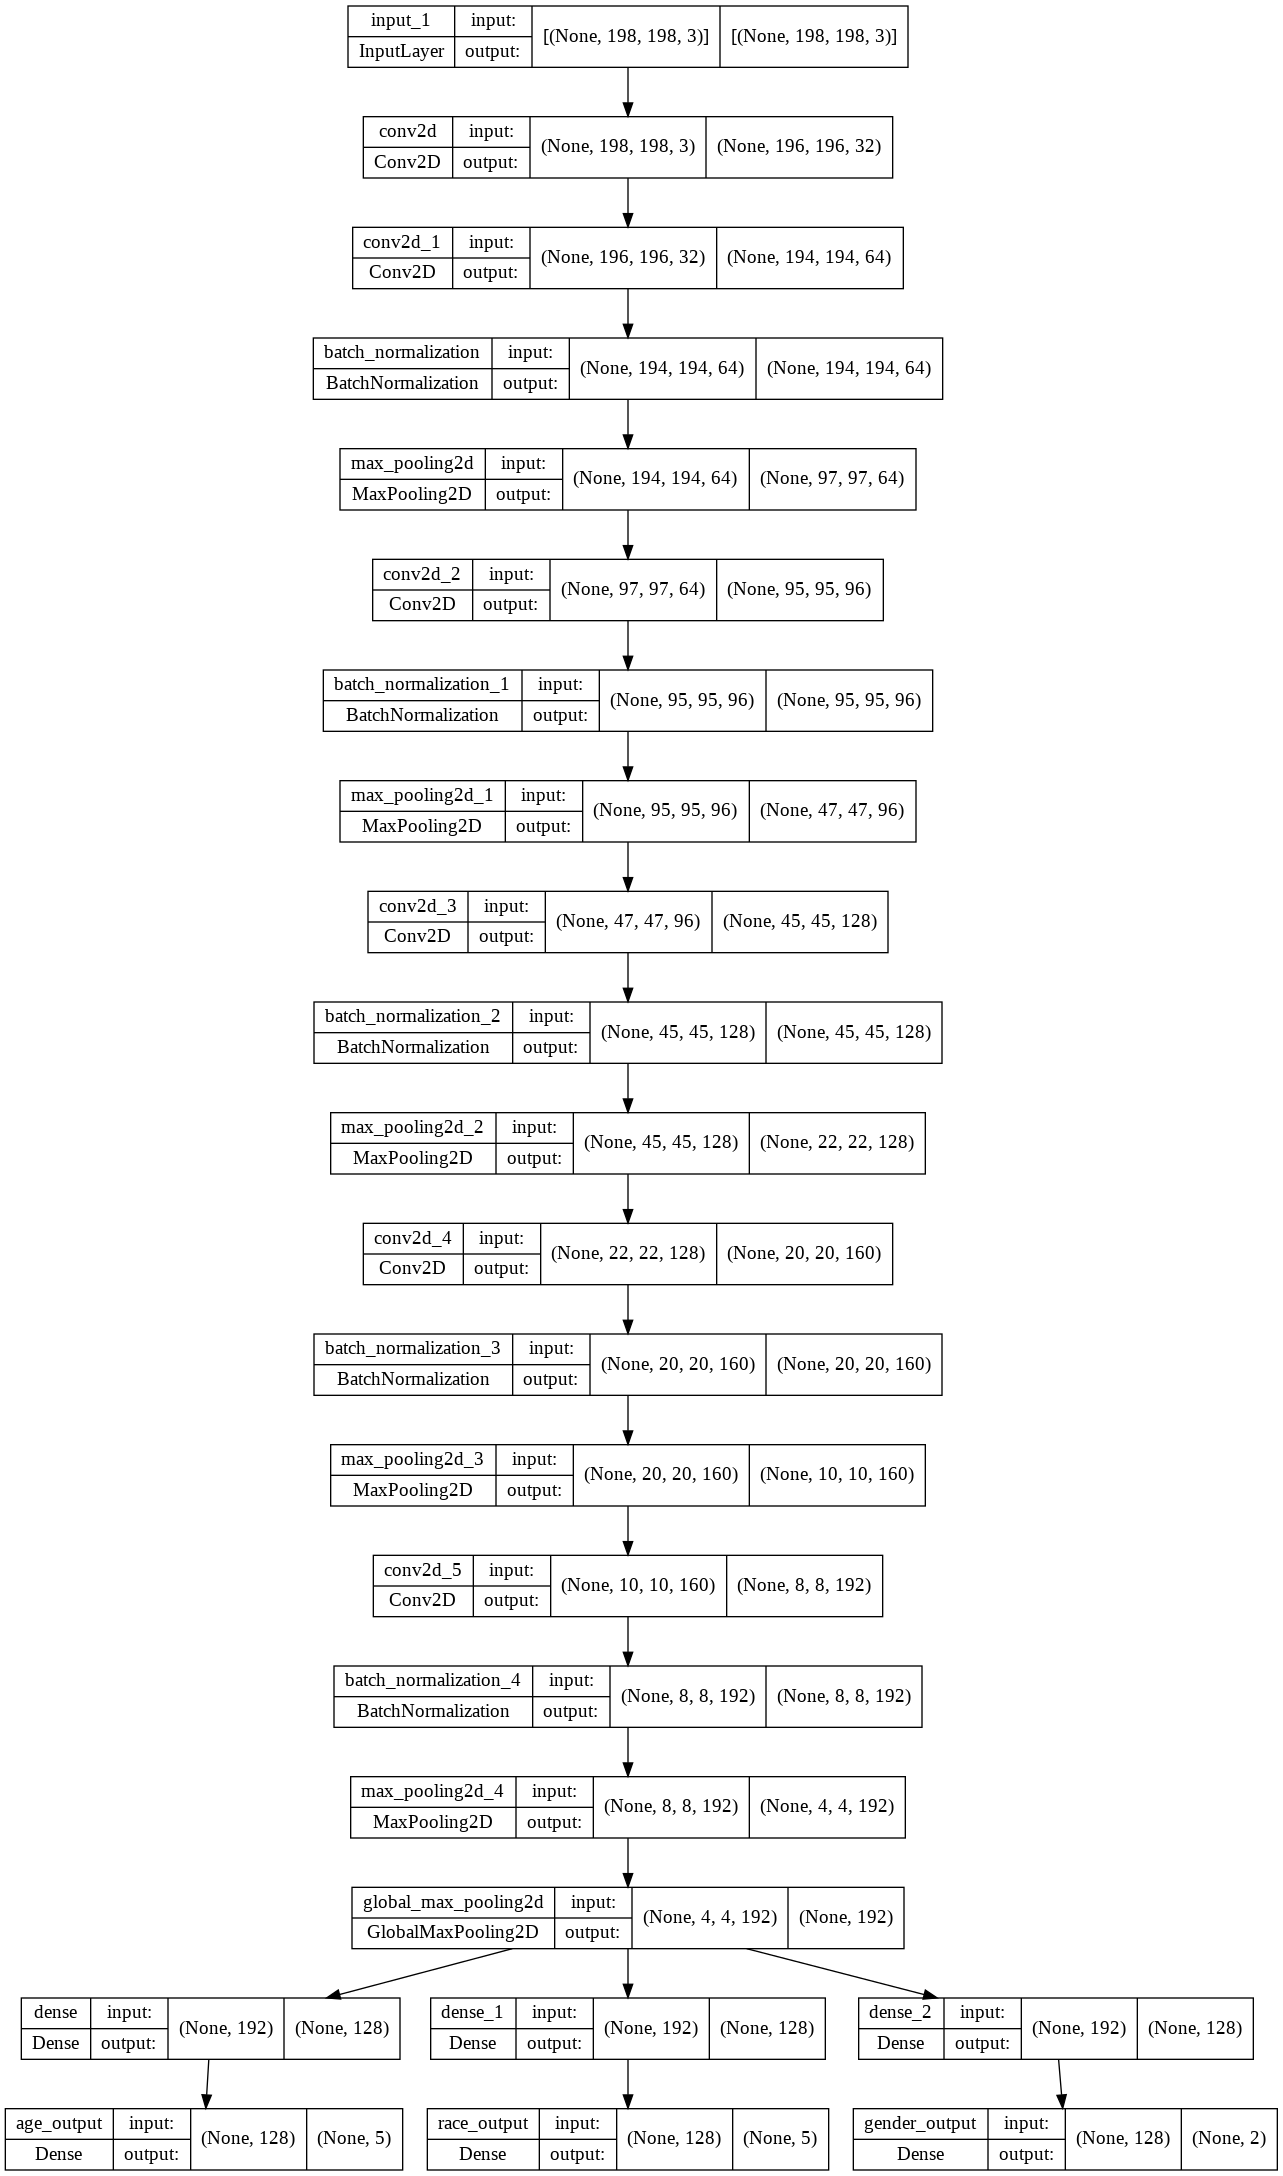

In [14]:

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age_id'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(to_categorical(age, len(AGE_ID_MAP)))
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=20,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
181/181 [==============================] - 68s 362ms/step - loss: 5.4295 - age_output_loss: 1.4129 - race_output_loss: 1.3083 - gender_output_loss: 0.6412 - age_output_accuracy: 0.4409 - race_output_accuracy: 0.5077 - gender_output_accuracy: 0.6783 - val_loss: 6.7941 - val_age_output_loss: 1.7037 - val_race_output_loss: 1.5593 - val_gender_output_loss: 1.0478 - val_age_output_accuracy: 0.2390 - val_race_output_accuracy: 0.2332 - val_gender_output_accuracy: 0.5258
Epoch 2/20
181/181 [==============================] - 65s 361ms/step - loss: 3.9867 - age_output_loss: 1.0890 - race_output_loss: 0.9292 - gender_output_loss: 0.4149 - age_output_accuracy: 0.5675 - race_output_accuracy: 0.6550 - gender_output_accuracy: 0.8108 - val_loss: 4.9058 - val_age_output_loss: 1.2952 - val_race_output_loss: 1.0960 - val_gender_output_loss: 0.6715 - val_age_output_accuracy: 0.4580 - val_race_output_accuracy: 0.5828 - val_gender_output_accuracy: 0.6420
Epoch 3/20
181/181 [======================

In [18]:
model.save('AGR_Model.h5')
model.save('AGR_Model')

INFO:tensorflow:Assets written to: AGR_Model/assets


In [72]:
model = keras.models.load_model('AGR_Model.h5')


# Visualize Results

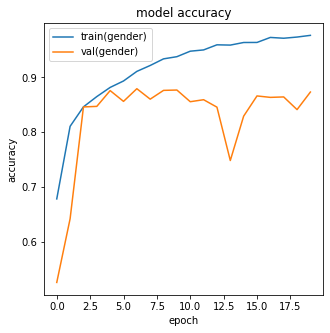

In [31]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train(gender)', 'val(gender)'], loc='upper left')
plt.show()

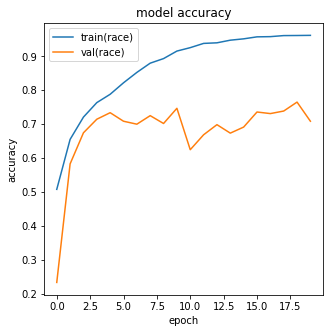

In [32]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['race_output_accuracy'])
plt.plot(history.history['val_race_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train(race)', 'val(race)'], loc='upper left')
plt.show()

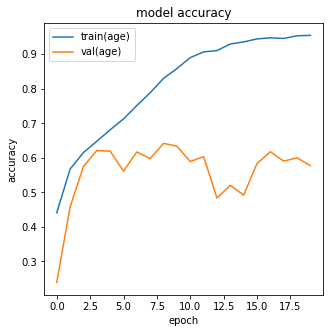

In [33]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['age_output_accuracy'])
plt.plot(history.history['val_age_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train(age)', 'val(age)'], loc='upper left')
plt.show()

In [34]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


{'age_output_accuracy': 0.5830965638160706,
 'age_output_loss': 2.2230043411254883,
 'gender_output_accuracy': 0.8660511374473572,
 'gender_output_loss': 0.48916950821876526,
 'loss': 7.244816303253174,
 'race_output_accuracy': 0.7100852131843567,
 'race_output_loss': 1.539759635925293}

In [120]:
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

race_pred, gender_pred, age_pred  = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1), age_pred.argmax(axis=-1)
race_true, gender_true, age_true  = race_true.argmax(axis=-1), gender_true.argmax(axis=-1), age_true.argmax(axis=-1)

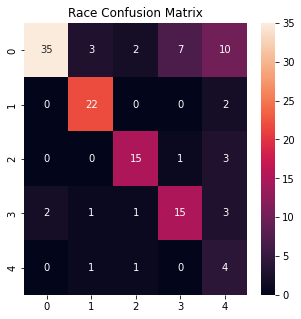

In [121]:
# Race Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import * 
import seaborn as sns
plt.rcParams['figure.figsize'] = 5, 5
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Race Confusion Matrix')
sns.heatmap(confusion_matrix(race_true, race_pred), annot=True)
plt.show()

In [122]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score

print( 'Accuracy:', accuracy_score(race_true, race_pred))
print( 'F1 score:', f1_score(race_true, race_pred, average='weighted'))
print( 'Recall:', recall_score(race_true, race_pred, average='weighted'))
print( 'Precision:', precision_score(race_true, race_pred, average='weighted'))


Accuracy: 0.7109375
F1 score: 0.7385440878479052
Recall: 0.7109375
Precision: 0.8118219504089069


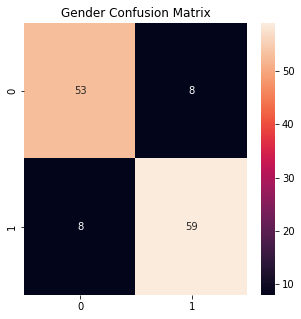

In [37]:
# Gender Confusion MAtrix

plt.rcParams['figure.figsize'] = 5, 5
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Gender Confusion Matrix')
sns.heatmap(confusion_matrix(gender_true, gender_pred), annot=True)
plt.show()

In [123]:

print( 'Accuracy:', accuracy_score(gender_true, gender_pred))
print( 'F1 score:', f1_score(gender_true, gender_pred, average='weighted'))
print( 'Recall:', recall_score(gender_true, gender_pred, average='weighted'))
print( 'Precision:', precision_score(gender_true, gender_pred, average='weighted'))


Accuracy: 0.8125
F1 score: 0.8131908621960207
Recall: 0.8125
Precision: 0.8174486803519061


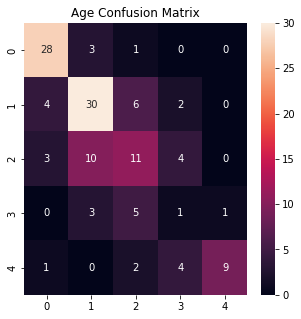

In [38]:
# Age Matrix
plt.rcParams['figure.figsize'] = 5, 5
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Age Confusion Matrix')
sns.heatmap(confusion_matrix(age_true, age_pred), annot=True)
plt.show()

In [124]:

print( 'Accuracy:', accuracy_score(age_true, age_pred))
print( 'F1 score:', f1_score(age_true, age_pred, average='weighted'))
print( 'Recall:', recall_score(age_true, age_pred, average='weighted'))
print( 'Precision:', precision_score(age_true, age_pred, average='weighted'))


Accuracy: 0.6796875
F1 score: 0.684293343365924
Recall: 0.6796875
Precision: 0.7044532946545323


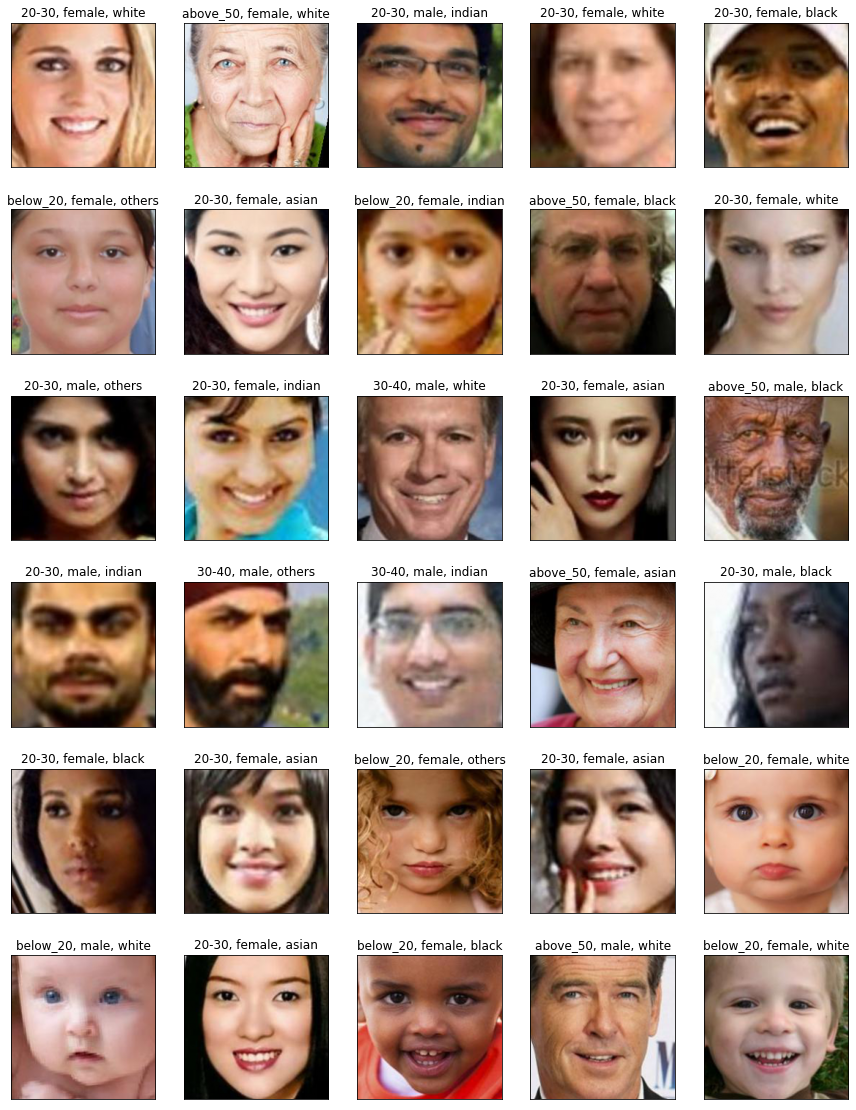

In [47]:

import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('{}, {}, {}'.format(ID_AGE_MAP[age_pred[img_idx]], ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])

**EMOTION MODEL**

In [86]:
! kaggle datasets download -d msambare/fer2013

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [89]:
%rm -rf /content/train

In [90]:
!unzip -q fer2013.zip

In [92]:
%rm -rf /content/test/surprise
%rm -rf /content/test/fear
%rm -rf /content/test/disgust

%rm -rf /content/train/surprise
%rm -rf /content/train/fear
%rm -rf /content/train/disgust

In [93]:
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [94]:
train_dir = 'train'
val_dir = 'test'
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(198,198),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(198,198),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')
test_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(198,198),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        subset='validation')

Found 21005 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.
Found 4201 images belonging to 4 classes.


In [163]:
len(train_generator)

449

In [127]:
from keras.layers import Activation, Dropout, Flatten, Dense
input_layer = Input(shape=(198, 198, 1))
x = Conv2D(filters=32, kernel_size=3, activation='relu')(input_layer)

x = Conv2D(filters=32*2, kernel_size=3, activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(filters=32*4, kernel_size=3, activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(filters=32*4, kernel_size=3, activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

emo_output = Dense(units=4, activation='softmax')(x)

emotion_model = Model(inputs=input_layer, outputs=emo_output)


In [96]:
import tensorflow as tf
emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001, decay=1e-4),metrics=['accuracy'])
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=21005 // 128,
        epochs=25,
        validation_data=validation_generator,
        validation_steps=5212 // 128)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


164/164 [==============================] - 46s 274ms/step - loss: 1.4278 - accuracy: 0.3436 - val_loss: 1.3347 - val_accuracy: 0.3547
Epoch 2/25
164/164 [==============================] - 43s 264ms/step - loss: 1.3233 - accuracy: 0.3750 - val_loss: 1.2923 - val_accuracy: 0.4359
Epoch 3/25
164/164 [==============================] - 44s 266ms/step - loss: 1.2643 - accuracy: 0.4307 - val_loss: 1.2789 - val_accuracy: 0.4062
Epoch 4/25
164/164 [==============================] - 43s 262ms/step - loss: 1.2335 - accuracy: 0.4512 - val_loss: 1.1826 - val_accuracy: 0.4922
Epoch 5/25
164/164 [==============================] - 43s 260ms/step - loss: 1.1819 - accuracy: 0.4855 - val_loss: 1.1531 - val_accuracy: 0.4898
Epoch 6/25
164/164 [==============================] - 42s 259ms/step - loss: 1.1737 - accuracy: 0.4866 - val_loss: 1.1208 - val_accuracy: 0.5207
Epoch 7/25
164/164 [==============================] - 42s 258ms/step - loss: 1.1374 - accuracy: 0.5025 - val_loss: 1.1395 - val_accuracy: 0.4

# Visualize Results

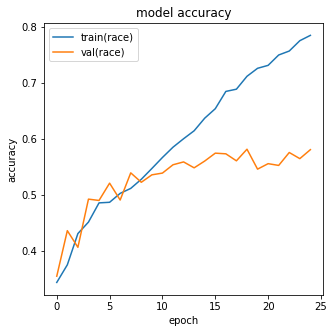

In [97]:
import keras
from matplotlib import pyplot as plt
plt.plot(emotion_model_info.history['accuracy'])
plt.plot(emotion_model_info.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train(race)', 'val(race)'], loc='upper left')
plt.show()

In [126]:
emotion_model.save('EMO_model.h5')
model.save('AGR_Model.h5')

In [ ]:
loss, acc = emotion_model.evaluate_generator(test_generator, steps=3, verbose=0)

In [106]:
print(acc,loss)

0.9479166865348816 0.2568225860595703


In [112]:

x_test, (emo_true)= next(test_generator)
emo_pred = emotion_model.predict_on_batch(x_test)

emo_pred  = emo_pred.argmax(axis=-1)
emo_true  = emo_true.argmax(axis=-1)


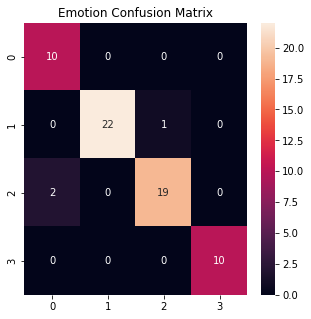

In [113]:
# Age Matrix
plt.rcParams['figure.figsize'] = 5, 5
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Emotion Confusion Matrix')
sns.heatmap(confusion_matrix(emo_true, emo_pred), annot=True)
plt.show()

In [118]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score

print( 'Accuracy:', accuracy_score(emo_true, emo_pred))
print( 'F1 score:', f1_score(emo_true, emo_pred, average='weighted'))
print( 'Recall:', recall_score(emo_true, emo_pred, average='weighted'))
print( 'Precision:', precision_score(emo_true, emo_pred, average='weighted'))


Accuracy: 0.953125
F1 score: 0.95380019709288
Recall: 0.953125
Precision: 0.9575520833333333
